In [32]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import torch
import torchaudio


import librosa 
import librosa.display
import IPython.display as ipd
import warnings
import seaborn as sns

import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

# from resnest.torch import resnest50

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [33]:
data = pd.read_csv("../input/birdclef-2021/train_metadata.csv")
data.describe()
data.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


In [35]:
fig = go.Figure(data=[go.Bar(y=data.common_name.value_counts().values, x=data.common_name.value_counts().index,marker_color='pink')])

fig.update_layout(title='Distribution of Bird Species')
fig.show()

In [36]:
hist_data = pd.to_datetime(data.time,errors='coerce').dropna().dt.hour.values.tolist()
fig = go.Figure(data=[go.Histogram(x=hist_data, histnorm='probability',marker_color='pink')])
fig.update_layout(title='Time of the day at which data is obtained')

fig.show()

In [37]:
# These part comes from https://www.kaggle.com/code/kneroma/birdclef-mels-computer-public/notebook
# Generate a huge dataset with duration, filepath, fold index, and more. 

PART_ID = 0 # The start index in the below list, by changing it you will compute mels on another subset
PART_INDEXES = [0,15718, 31436, 47154, 62874] # The train_set is splitted into 4 subsets

SR = 32_000
DURATION = 7 
SEED = 666

DATA_ROOT = Path("../input/birdclef-2021")
TRAIN_AUDIO_ROOT = Path("../input/birdclef-2021/train_short_audio")
TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("audio_images") # Where to save the mels images
TRAIN_AUDIO_IMAGES_SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [38]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [39]:
def make_df(n_splits=5, seed=SEED, nrows=None):
    
    df = pd.read_csv(DATA_ROOT/"train_metadata.csv", nrows=nrows)

    LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
    
    df = df.iloc[PART_INDEXES[PART_ID]: PART_INDEXES[PART_ID+1]]

    df["label_id"] = df["primary_label"].map(LABEL_IDS)

    df["filepath"] = [str(TRAIN_AUDIO_ROOT/primary_label/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.filepath]

    df = pd.concat([df, pd.DataFrame(pool(tqdm(tasks)))], axis=1, sort=False)
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.label_id.values)
    df["fold"] = -1

    for fold, (train_set, val_set) in enumerate(splits):
        
        df.loc[df.index[val_set], "fold"] = fold

    return LABEL_IDS, df

In [40]:
from  sklearn.model_selection  import StratifiedKFold

LABEL_IDS, df = make_df(nrows=None)

df.to_csv("rich_train_metadata.csv", index=True)
with open("LABEL_IDS.json", "w") as f:
    json.dump(LABEL_IDS, f)

print(df.shape)
df.head()

  0%|          | 0/15718 [00:00<?, ?it/s]

(15718, 20)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,label_id,filepath,frames,sr,duration,fold
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2


<AxesSubplot:>

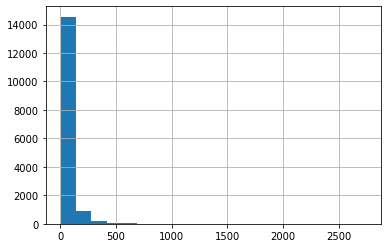

In [42]:
df["duration"].hist(bins=20)

<AxesSubplot:>

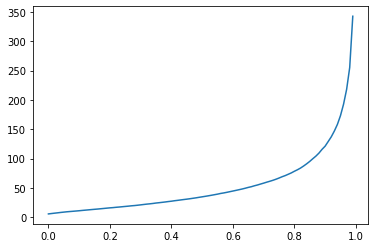

In [43]:
df["duration"].quantile(np.arange(0, 1, 0.01)).plot()

In [44]:
df_0 = df[df['fold'] == 0]
df_0_under_60 = df_0[df_0['duration'] <= 60.0]
fig = go.Figure(data=[go.Bar(y=df_0_under_60.primary_label.value_counts().values, x=df_0_under_60.primary_label.value_counts().index,marker_color='pink')])

fig.update_layout(title='Distribution of Bird Species in fold 0 with duration under 60 seconds')
fig.show()

In [45]:
# Audio Normalization
NUM_AUDIO_PER_LABEL = 8 
audio_per_label = {}

for label in os.listdir('../input/birdclef-2021/train_short_audio/'):
    audio_per_label[label] = []
    audio_filenames = random.sample(os.listdir('../input/birdclef-2021/train_short_audio/'+label), NUM_AUDIO_PER_LABEL)
    # append path to that file
    for audio_filename in audio_filenames:
        audio_per_label[label].append('../input/birdclef-2021/train_short_audio/'+label+'/'+audio_filename)
    

In [46]:
# A sample audio. Change species_id to select different label
sample_audio = audio_per_label['caltow'][0]
# Load unnormalized audio
audio, sr = librosa.load(sample_audio)
# Normalize audio
norm_audio = librosa.util.normalize(audio)

In [47]:
print(norm_audio) # ?How to normalize the bird song. 

[-7.6607621e-06 -5.6658100e-05 -7.5880042e-04 ...  8.6907163e-04
 -1.7417065e-03  0.0000000e+00]


In [55]:
df_0_under_60_rating5 = df_0_under_60[df_0_under_60['rating'] == 5]
sound_sample = df_0_under_60_rating5.iloc[[1]]['filepath'].values[0]

In [56]:
def knn_filter(y):
    S_full, phase = librosa.magphase(librosa.stft(y))

    # We'll compare frames using cosine similarity, and aggregate similar frames
    # by taking their (per-frequency) median value.
    #
    # To avoid being biased by local continuity, we constrain similar frames to be
    # separated by at least 2 seconds.
    #
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.

    S_filter = librosa.decompose.nn_filter(
        S_full,
        aggregate=np.median,
        metric="cosine",
        width=int(librosa.time_to_frames(2, sr=sr)),
    )

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimum
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)

    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin = 10
    mask = librosa.util.softmask(S_full - S_filter, margin * S_filter, power=2)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components
    S_foreground = mask * S_full
    y_foreground = librosa.istft(S_foreground * phase)

    # play back the entire file
    display(Audio(y_foreground, rate=sr))
    plot_melspectogram(np.real(y_foreground), sr)

def plot_melspectogram(y, sr, n_mels=128, **kwargs):
    """Plot a melspectrogram of an audio file."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, **kwargs)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr)
    plt.show()

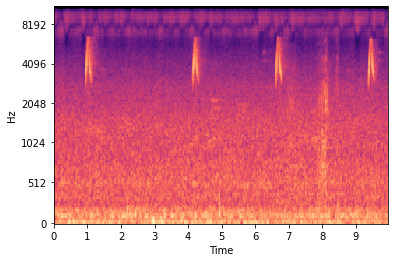

In [57]:
y,sr = librosa.load(sound_sample)
plot_melspectogram(y, sr)

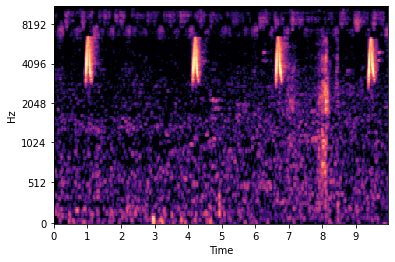

In [58]:
knn_filter(y)

In [68]:
from scipy import signal
import random

# Remove low frequencies, add a high pass filter
def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

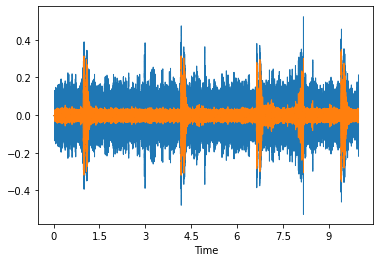

In [73]:
yf1 = f_high(y, sr)
librosa.display.waveshow(y,sr=sr, x_axis='time');
librosa.display.waveshow(yf1,sr=sr, x_axis='time');

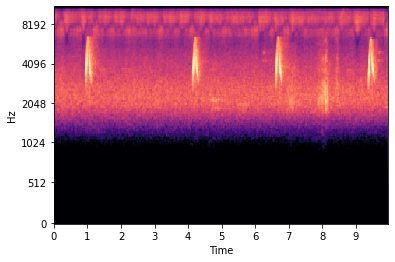

In [74]:
plot_melspectogram(yf1, sr)

In [75]:
# PCEN: Still need some time to do research

## Short time Fourier Transform

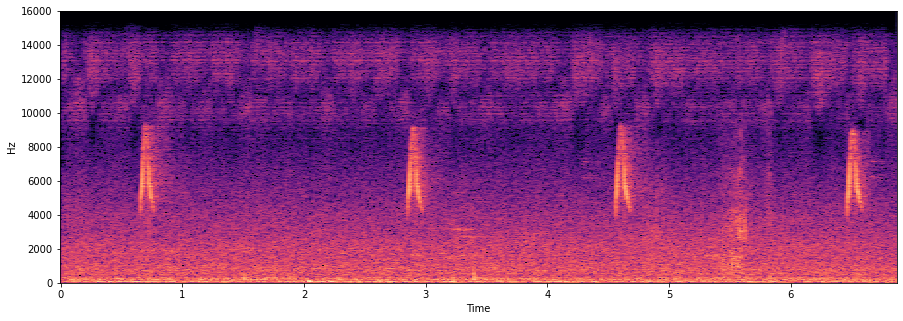

In [78]:
spec = librosa.stft(y)
spec_db = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure(figsize=(15, 5))
librosa.display.specshow(spec_db, sr=32000, x_axis='time', y_axis='hz')

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning:

amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.



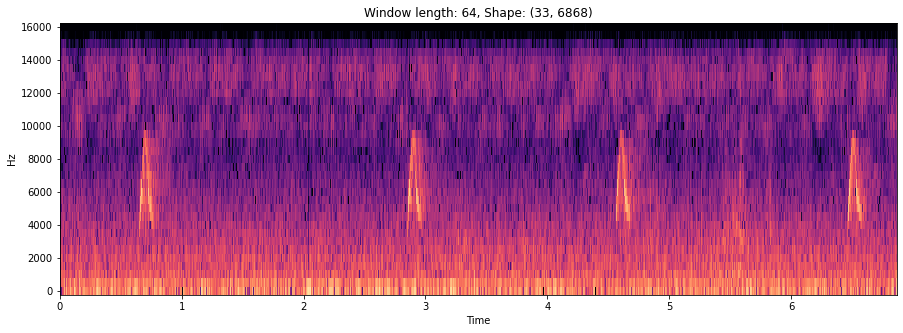

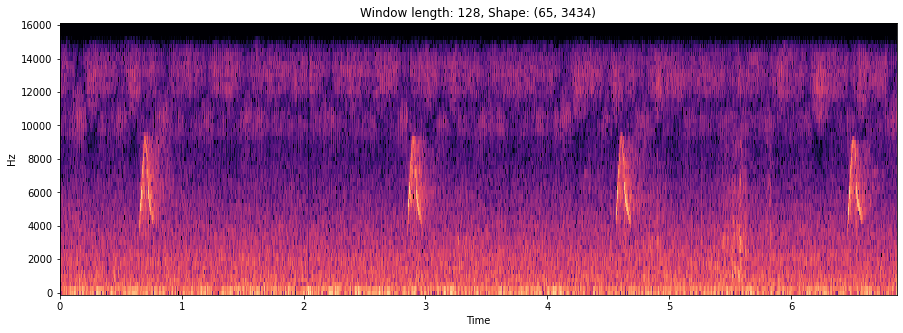

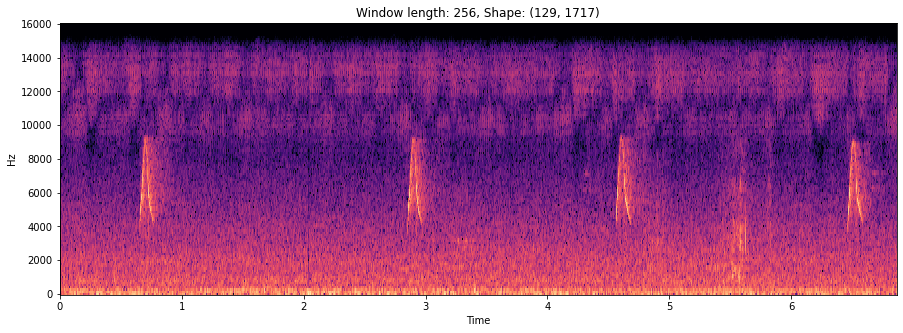

In [80]:
# Windown function
window = [64, 128, 256]
for win_length in window:
    
    hop_length = win_length // 2
    spec = librosa.stft(y, n_fft=win_length, hop_length=hop_length)
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    
    # Show plot
    plt.figure(figsize=(15, 5))
    plt.title('Window length: ' + str(win_length) + ', Shape: ' + str(spec_db.shape))
    librosa.display.specshow(spec_db, sr=32000, hop_length=hop_length, x_axis='time', y_axis='hz')

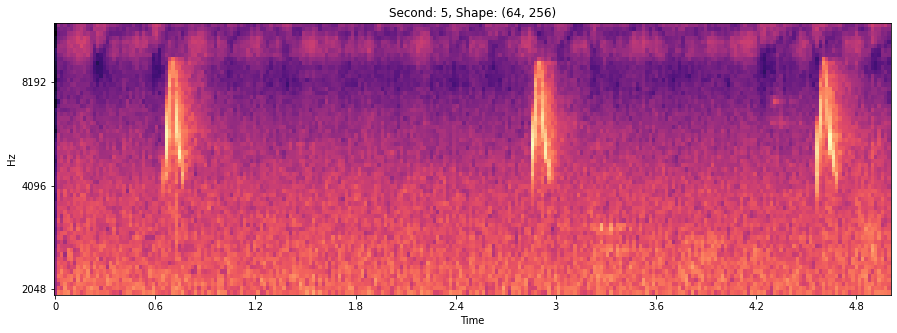

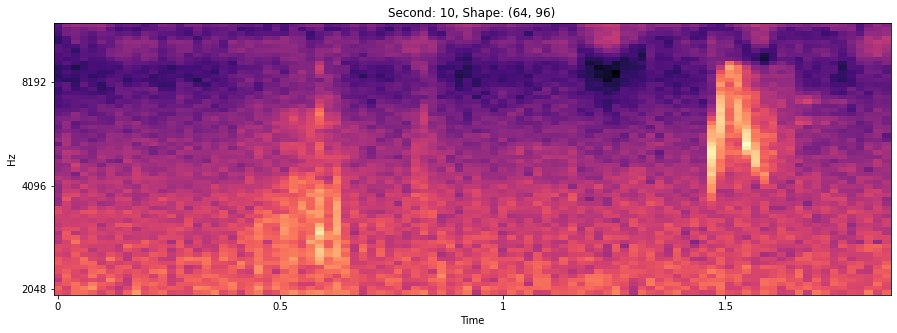

In [83]:
# THESE PARTS FROM BIREDCLEF2021
SPEC_HEIGHT = 64
SPEC_WIDTH = 256

NUM_MELS = SPEC_HEIGHT
HOP_LENGTH = int(32000 * 5 / (SPEC_WIDTH - 1)) # sample rate * duration / spec width - 1 == 627


FMIN = 2000
FMAX = 12000

# Let's get all three spectrograms
for second in [5, 10]:  
    
    # Get start and stop sample
    s_start = (second - 5) * 32000
    s_end = second * 32000

    # Compute the spectrogram and apply the mel scale
    mel_spec = librosa.feature.melspectrogram(y=y[s_start:s_end], 
                                              sr=32000, 
                                              n_fft=1024, 
                                              hop_length=HOP_LENGTH, 
                                              n_mels=NUM_MELS, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Show the spec
    plt.figure(figsize=(15, 5))
    plt.title('Second: ' + str(second) + ', Shape: ' + str(mel_spec_db.shape))
    librosa.display.specshow(mel_spec_db, 
                             sr=32000, 
                             hop_length=HOP_LENGTH, 
                             x_axis='time', 
                             y_axis='mel',
                             fmin=FMIN, 
                             fmax=FMAX)

## Energy and RMSE

In [59]:
print(librosa.__version__)

0.9.2


In [60]:
# Energy
hop_length = 256
frame_length = 512

energy = np.array([sum(abs(y[i:i+frame_length]**2)) for i in range(0, len(y), hop_length)])


# RMSE
rmse = librosa.feature.rms(y, frame_length=frame_length, hop_length=hop_length, center=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Pass y=[ 0.00060795  0.00092464  0.00072671 ... -0.01600678 -0.02432985
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error



In [67]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

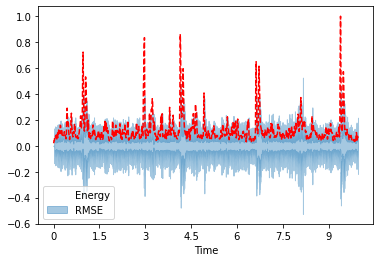

In [62]:
librosa.display.waveshow(y, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') 
plt.legend(('Energy', 'RMSE'))

## MetaData + Train_Aduio Sample

In [6]:
dups_primary_label = data.pivot_table(columns=['primary_label'], aggfunc='size')
dups_primary_label.sort_values(ascending=False)

primary_label
redcro     500
comrav     500
houspa     500
norcar     500
barswa     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
crfpar       8
stvhum2      8
Length: 397, dtype: int64

In [19]:
base_dir = '../input/birdclef-2021/train_short_audio'
data['full_path'] = base_dir+ '/' + data['primary_label'] + '/' + data['filename']

*There are totally 397 birds in the train_metadata dataset, and the top five frequency bird is redcro, comrav, houspa, norcar, and barswa.*

In [20]:
redcro = data[data['primary_label'] == "redcro"].head(1)['full_path'].values[0]
comrav = data[data['primary_label'] == "comrav"].head(1)['full_path'].values[0]
houspa = data[data['primary_label'] == "houspa"].head(1)['full_path'].values[0]
norcar = data[data['primary_label'] == "norcar"].head(1)['full_path'].values[0]
barswa = data[data['primary_label'] == "barswa"].head(1)['full_path'].values[0]

label_list = [redcro, comrav, houspa, norcar, barswa]

In [21]:
redcro

'../input/birdclef-2021/train_short_audio/redcro/XC110116.ogg'

In [22]:
ipd.Audio(redcro)

In [49]:
# Waveform
def waveform(label):
    y,sr = librosa.load(label)
    fig, ax = plt.subplots(1,figsize = (12, 5))
    librosa.display.waveshow(y,sr)
    ax.set(title='waveform')
   
    
def mfcc(label):
    y,sr = librosa.load(label)
    S = librosa.feature.mfcc(y, sr)
    fig, ax = plt.subplots(1,figsize = (12, 5))
    img = librosa.display.specshow(S, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning:

Pass y=[-3.0921852e-05 -2.4451017e-05 -2.9929166e-05 ... -4.3454273e-03
 -6.3311839e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error



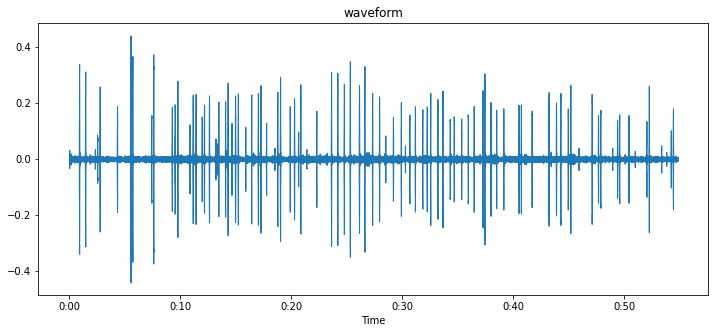

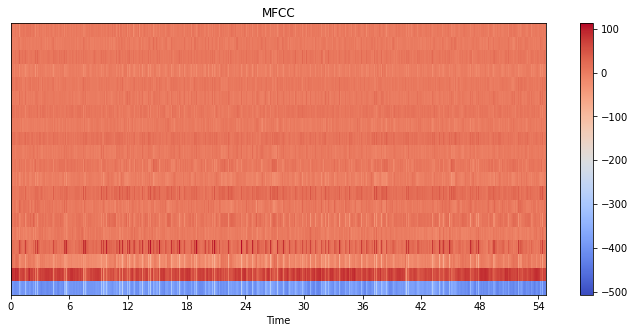

In [63]:
# for elem in label_list:
#     waveform(elem)
#     mel_spectrogram(elem)
#     mfcc(elem)
waveform(redcro)
mfcc(redcro)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Pass y=[-3.0921852e-05 -2.4451017e-05 -2.9929166e-05 ... -4.3454273e-03
 -6.3311839e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error



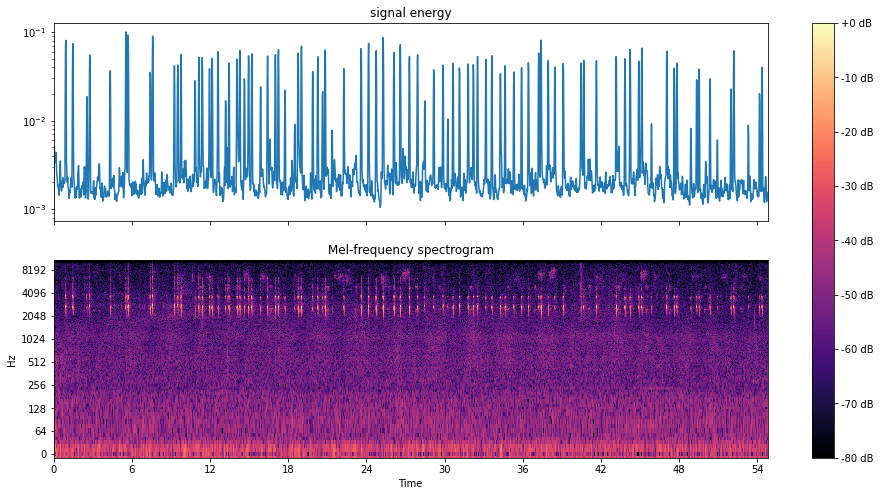

In [74]:
def mel_rmse(label):
    y_label, sr_label = librosa.load(label)
    audio_label, _ = librosa.effects.trim(y_label)
    S, phase = librosa.magphase(librosa.stft(audio_label))
    S_db=librosa.amplitude_to_db(S, ref=np.max)
    rms = librosa.feature.rms(S=S)
    
    fig, ax = plt.subplots(nrows=2, sharex=True,figsize = (16, 8))
    
    times = librosa.times_like(rms)
    ax[0].semilogy(times, rms[0], label='RMS Energy')
    ax[0].set(xticks = [])
    ax[0].label_outer()
    ax[0].set(title = 'signal energy')
    
    S_2 = librosa.feature.melspectrogram(y_label, sr_label)
    S_dB_2 = librosa.power_to_db(S_2, ref = np.max)
    img = librosa.display.specshow(S_dB_2, x_axis='time', y_axis='mel', sr=sr_label,fmax=8000, ax=ax[1]) # hop_length = 100
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    
    librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax[1])
    ax[1].set(title = 'Mel-frequency spectrogram')
    plt.show()
    
mel_rmse(redcro)

In [27]:
# # Metadata
# fig, ax = plt.subplots(1,figsize = (12, 5))
# ax = data['primary_label'].value_counts()[0:30].plot.bar()
# ax.set(title='Top 30 Birds Record')

In [28]:
# # Here we use a column with categorical data
# fig = px.histogram(data, x="primary_label", title = 'all birds count', width=800, height=400)
# fig.show()

# dfg = data.groupby(['primary_label']).size().to_frame().sort_values([0], ascending = False).head(30).reset_index()
# dfg.columns = ['primary_label', 'count']
# fig = px.histogram(dfg, x='primary_label', y = 'count', opacity=0.8, title = 'Top 30 Birds Record', width=800, height=400)
# fig.show()

In [14]:
# fig = px.scatter_geo(data, lat = data['latitude'], lon = data['longitude'], color = data['common_name'], width=800, height=400)
# fig.show()

In [13]:
# dfg = data.groupby(['rating']).size().to_frame().sort_values([0], ascending = False).head(11).reset_index()
# dfg.columns = ['rating', 'count']
# fig = px.histogram(dfg, x='rating', y = 'count', opacity=0.6, title = 'Rating Count', width=800, height=400, nbins=11)
# fig.show()

In [29]:
# redcro_song = data[data['primary_label'] == "redcro"]
# redcro_song_5 = redcro_song[redcro_song['rating'] == 5.0]
# ipd.Audio(redcro_song_5.iloc[:1]['full_path'].values[0])

In [30]:
# mel_rmse(redcro_song_5.iloc[:1]['full_path'].values[0])

In [31]:
# # Random Select
# redcro_random = redcro_song_5.sample(1, random_state = 1)['full_path'].values[0]
# ipd.Audio(redcro_random)

In [32]:
# mel_rmse(redcro_random)

In [33]:
# song_2 = data[data['rating'] == 2.0]
# ipd.Audio(song_2.iloc[:1]['full_path'].values[0])

In [ ]:
# Some ideas in mind:
# Variantion in length, how to choose the best slice window time range (1. choose different window length based on rating)
# write a function, when energy peak, use the window to slice it. 